In [154]:
import numpy as np
import pandas as pd
from scipy import stats as sps
from matplotlib import pyplot as plt
from skimage import io
import skimage
import time
from PIL import Image
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.mixture import GaussianMixture

from sklearn.cluster import KMeans
from sklearn.model_selection import KFold
from sklearn.metrics import silhouette_score as ss
!pip install scikit-learn-extra

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!unzip '/content/drive/My Drive/Colab Notebooks/ClusteringDataset/HumanActivity.zip'

Archive:  /content/drive/My Drive/Colab Notebooks/ClusteringDataset/HumanActivity.zip
  inflating: test.csv                
  inflating: train.csv               


###a

In [102]:
trainDataset = pd.read_csv('/content/train.csv')
testDataset = pd.read_csv('/content/test.csv')

In [103]:
print("Train Set -- Number of Samples : ", trainDataset.shape[0], "Number of Features: ", trainDataset.shape[1])
print("Test Set  -- Number of Samples : ", testDataset.shape[0], "Number of Features: ", trainDataset.shape[1])
print("NaN Values exist: ",trainDataset.isnull().values.any())
print("Number of Categorical Variables: ", 2, 'Activity and Subject')


Train Set -- Number of Samples :  7352 Number of Features:  563
Test Set  -- Number of Samples :  2947 Number of Features:  563
NaN Values exist:  False
Number of Categorical Variables:  2 Activity and Subject


LAYING                1407
STANDING              1374
SITTING               1286
WALKING               1226
WALKING_UPSTAIRS      1073
WALKING_DOWNSTAIRS     986
Name: Activity, dtype: int64


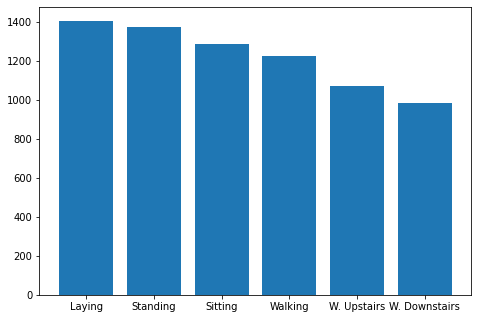

In [104]:
fig = plt.figure()
fig.xlabel = "Activity Labels"
fig.ylabel = "Number of Samples"
ax = fig.add_axes([0,0,1,1])
labels = ['Laying', 'Standing', 'Sitting', 'Walking', 'W. Upstairs', 'W. Downstairs']
print(trainDataset['Activity'].value_counts())
ax.bar(labels, trainDataset['Activity'].value_counts(sort = True))
plt.show()


All the parameters attached with this dataset are numerical except the subject and Activity parameters which are categorical. We are getting rid of them either way before clustering. There are no NaN values since all the data is available. And the dataset is also unbalanced as seen in the histogram.




###b

In [112]:

trainDataset['Activity'] = trainDataset['Activity'].replace('STANDING', 0)
trainDataset['Activity'] = trainDataset['Activity'].replace('SITTING', 1)
trainDataset['Activity'] = trainDataset['Activity'].replace('LAYING', 2)
trainDataset['Activity'] = trainDataset['Activity'].replace('WALKING', 3)
trainDataset['Activity'] = trainDataset['Activity'].replace('WALKING_DOWNSTAIRS', 4)
trainDataset['Activity'] = trainDataset['Activity'].replace('WALKING_UPSTAIRS', 5)


testDataset['Activity'] = testDataset['Activity'].replace('STANDING', 0)
testDataset['Activity'] = testDataset['Activity'].replace('SITTING', 1)
testDataset['Activity'] = testDataset['Activity'].replace('LAYING', 2)
testDataset['Activity'] = testDataset['Activity'].replace('WALKING', 3)
testDataset['Activity'] = testDataset['Activity'].replace('WALKING_DOWNSTAIRS', 4)
testDataset['Activity'] = testDataset['Activity'].replace('WALKING_UPSTAIRS', 5)

trainX = trainDataset.sample(frac=1).reset_index(drop=True)
trainX = trainX.sample(frac=1).reset_index(drop=True)
trainY = trainDataset['Activity']
trainX = trainX.drop(columns = ['subject', 'Activity'])
print("Train - ", trainX.shape)


testX = testDataset.sample(frac=1).reset_index(drop=True)
testX = testX.sample(frac=1).reset_index(drop=True)
testY = testX['Activity']
testX = testX.drop(columns = ['subject', 'Activity'])
print("Test -  ", testX.shape)

Train -  (7352, 561)
Test -   (2947, 561)


In [113]:

scaler = StandardScaler()
trainX = scaler.fit_transform(trainX)
trainX = pd.DataFrame(trainX)


scaler = StandardScaler()
testX = scaler.fit_transform(testX)
testX = pd.DataFrame(testX)


Converting all the labels to numerical values and removing all the categorical parameters from the training and testing set. Setting all the labels from 0 to 5, so the same number as the clusters which will allow me to check for scores later on in the evaluation. Other than that, no preprocessing was necessary since the data came preprocessed from the source. The values were already passed through noise filters and frequency filters. I standardized the data so that I could use the Gaussian Mixture model.

###c

In [114]:
pca = PCA(0.98, svd_solver='full').fit(trainX)
trainX = pca.transform(trainX)
print(trainX.shape)

(7352, 148)


In [115]:
pca = PCA(148, svd_solver='full').fit(testX)
testX = pca.transform(testX)
print(testX.shape)


pca_trainX = trainX
pca_testX = testX

(2947, 148)


In [106]:
pca_trainX = trainX 
pca_testX = testX

I used PCA to reduce dimensionality and get rid of parameters that did not have any effect on the entire dataset (low variance got thrown out). I tried to use the dataset without using PCA and I was getting a lot of overlapping clusters so for comparison I used PCA and saw relatively better results (especially for Gaussian Mixture)

###d


######K - Means Clusteirng

In [117]:
KFolds = KFold(6, shuffle = True)
KFolds.get_n_splits(pca_trainX)
KFolds.split(pca_trainX)
count = 0
pca_trainX = pd.DataFrame(pca_trainX)
tolValues = [5, 1, 0.1, 0.01, 0.001, 0.0001]
count = 0
for train_data, test_data in KFolds.split(pca_trainX):
  X_train, X_test = pca_trainX.iloc[train_data] , pca_trainX.iloc[test_data]
  Y_test = trainY.iloc[test_data]
  KMeansClg = KMeans(n_clusters= 6, init= 'random', n_init = 30, max_iter = 2000, tol = tolValues[count], algorithm ='full')
  KMeansClg.fit(X_train)
  resultKMeans = KMeansClg.predict(X_test)
  clusterDist = KMeansClg.inertia_ / X_test.shape[0]
  sil_score = ss(X_test, resultKMeans)
  print("Number of iterations: ", KMeansClg.n_iter_, "Tolerance: ", tolValues[count], "Average Sum Distance of all points to centroid: : ", round(clusterDist, 3), \
        "Silhouette Score: ", round(sil_score, 3))
  count  += 1

Number of iterations:  3 Tolerance:  5 Average Sum Distance of all points to centroid: :  1192.984 Silhouette Score:  0.104
Number of iterations:  11 Tolerance:  1 Average Sum Distance of all points to centroid: :  1172.668 Silhouette Score:  0.117
Number of iterations:  7 Tolerance:  0.1 Average Sum Distance of all points to centroid: :  1192.351 Silhouette Score:  0.117
Number of iterations:  17 Tolerance:  0.01 Average Sum Distance of all points to centroid: :  1181.501 Silhouette Score:  0.114
Number of iterations:  25 Tolerance:  0.001 Average Sum Distance of all points to centroid: :  1187.647 Silhouette Score:  0.114
Number of iterations:  26 Tolerance:  0.0001 Average Sum Distance of all points to centroid: :  1164.975 Silhouette Score:  0.115


In [149]:
KMeansClg = KMeans(n_clusters= 6, init= 'random', max_iter = 2000, tol = 1, algorithm ='full')
KMeansClg.fit(pca_trainX)
resultKMeans = KMeansClg.predict(pca_testX)
clusterDistKMean = KMeansClg.inertia_ / pca_testX.shape[0]
sil_score_KMean = ss(pca_testX, resultKMeans)
print("Number of iterations with updates Means: ", KMeansClg.n_iter_, "Tolerance: ", 1, "Average Sum Distance of all points to centroid: : ", round(clusterDistKMean, 3), \
      "Silhouette Score: ", round(sil_score_KMean, 3))

Number of iterations with updates Means:  8 Tolerance:  1 Average Sum Distance of all points to centroid: :  593.478 Silhouette Score:  0.119


###### K Mediods


In [119]:
from sklearn_extra.cluster import KMedoids
iterations = [500, 600, 900 , 1000, 1300, 1500]
KFolds = KFold(6, shuffle = True)
KFolds.get_n_splits(pca_trainX)
KFolds.split(pca_trainX)
KMediod_error = 0
count = 0
pca_trainX = pd.DataFrame(pca_trainX)
for train_data, test_data in KFolds.split(pca_trainX):
  X_train, X_test = pca_trainX.iloc[train_data] , pca_trainX.iloc[test_data]
  Y_test = trainY.iloc[test_data]
  KMedoidClg = KMedoids(n_clusters = 6, metric = 'manhattan', init = 'random', max_iter = iterations[count])
  KMedoidClg.fit(X_train)
  resultKMedoid = KMedoidClg.predict(X_test)
  clusterDist = KMedoidClg.inertia_ / X_test.shape[0]
  sil_score = ss(X_test, resultKMedoid)
  print("Number of Iterations: ", iterations[count], "Average Sum Distance of all points to centroid: : ", round(clusterDist, 3), \
      "Silhouette Score: ", round(sil_score, 3))
  count  += 1

Number of Iterations:  500 Average Sum Distance of all points to centroid: :  737.887 Silhouette Score:  0.036
Number of Iterations:  600 Average Sum Distance of all points to centroid: :  736.326 Silhouette Score:  0.029
Number of Iterations:  900 Average Sum Distance of all points to centroid: :  730.943 Silhouette Score:  0.101
Number of Iterations:  1000 Average Sum Distance of all points to centroid: :  730.339 Silhouette Score:  0.073
Number of Iterations:  1300 Average Sum Distance of all points to centroid: :  731.301 Silhouette Score:  0.045
Number of Iterations:  1500 Average Sum Distance of all points to centroid: :  726.428 Silhouette Score:  -0.009


In [152]:
KMedoidClg = KMedoids(n_clusters = 6, metric = 'manhattan', init = 'random', max_iter = 900)
KMedoidClg.fit(pca_trainX)
resultKMedoid = KMedoidClg.predict(pca_testX)
clusterDistKMedoid = KMedoidClg.inertia_ / pca_testX.shape[0]
sil_score_KMedoid = ss(pca_testX, resultKMedoid)
print("Number of Iterations: ", 900, "Average Sum Distance of all points to centroid: : ", round(clusterDistKMedoid, 3), \
    "Silhouette Score: ", round(sil_score_KMedoid, 3))

Number of Iterations:  900 Average Sum Distance of all points to centroid: :  369.434 Silhouette Score:  0.036


###### EM Clustering - Gaussian Mixture


In [121]:
KFolds = KFold(6, shuffle = True)
tolValues = [10, 1, 0.1, 0.01, 0.001, 0.0001]
KFolds.get_n_splits(pca_trainX)
KFolds.split(pca_trainX)

count = 0
pca_trainX = pd.DataFrame(pca_trainX)
for train_data, test_data in KFolds.split(pca_trainX):
  X_train, X_test = pca_trainX.iloc[train_data] , pca_trainX.iloc[test_data]
  Y_test = trainY.iloc[test_data]
  GMClg = GaussianMixture(n_components = 6, covariance_type= 'full', tol = tolValues[count], max_iter = 1000, n_init = 10, init_params = 'random')
  GMClg.fit(X_train)
  resultGM = GMClg.predict(X_test)
  sil_score = ss(X_test, Y_test)
  print("Tolerance: ", tolValues[count], "Score: ", sil_score)
  count  += 1

Tolerance:  10 Score:  -0.02220440468176362
Tolerance:  1 Score:  -0.027540037173796078
Tolerance:  0.1 Score:  -0.026901530668640768
Tolerance:  0.01 Score:  -0.02360228461586858
Tolerance:  0.001 Score:  -0.022578448504043745
Tolerance:  0.0001 Score:  -0.05814357132058353


In [125]:
GMClg = GaussianMixture(n_components = 6, covariance_type= 'full', tol = 0.01, max_iter = 1000, n_init = 15, init_params = 'random')
GMClg.fit(pca_trainX)
resultGM = GMClg.predict(pca_testX)
sil_score_GM = ss(pca_testX, testY)
print("Number of iterations with updates Means: ", 15, "Tolerance: ", 0.01, "Score: ", score)

Number of iterations with updates Means:  15 Tolerance:  0.01 Score:  0.06771541251422357


I used Kmeans and KMedoids to compare performance between Euclidian distance and Manhattan distance between clusters and how the clusters form depending on these distances. I also wanted to see which clusters form more densely between these two methods.

I used Gaussian Mixture, based on EM, to see optimal performance in clustering but I did not have very good luck with that. I did not see the results I was expecting.

I also cross validated some the parameters like number of iterations amd tolerance for these tasks as well and returned the best results with it.

###e


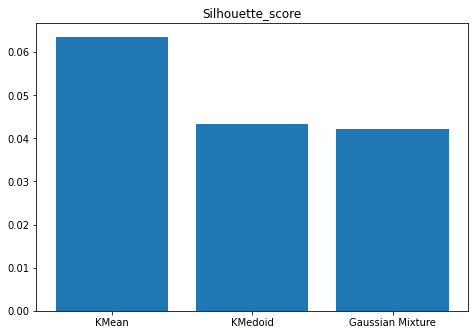

In [126]:
fig = plt.figure()

ax = fig.add_axes([0,0,1,1])
labels = ['KMean', 'KMedoid', 'Gaussian Mixture']
values = [sil_score_KMean, sil_score_KMedoid, sil_score_GM]
plt.title("Silhouette_score")
ax.bar(labels, values)
plt.show()


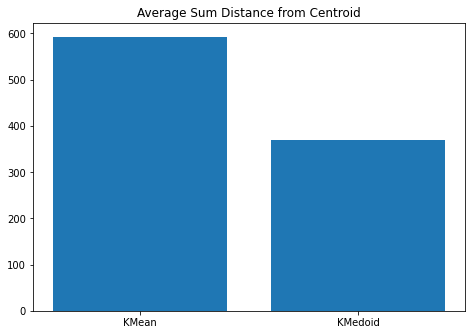

In [155]:
fig = plt.figure()

ax = fig.add_axes([0,0,1,1])
labels = ['KMean', 'KMedoid']
values = [clusterDistKMean, clusterDistKMedoid]
plt.title("Average Sum Distance from Centroid")
ax.bar(labels, values)
plt.show()


The best clusters were formed under KMean algorithm followed KMedoid and Gaussian Mixture being very close for the 2nd spot, this can be seen by the silhoutte score hiustogram.

By best clusters I mean, clusters forming away from other clusters relative to each sample in the cluster. 

I could not get the average sum distance for GM but the results for KMena and KMedoi are seen above. KMedoid seemed to have denser clusters compared to KMean.

###f
The ethical tasks for this dataaset could have occured while collecting the data. Although the participants volunteered, they would have been under pressure to approximately do a certain instances of each type of task and if someone was injured during data collection period, they would be "obligated" to finsih the collection to avoid discrepancies in data. The participants could also think of this as breach of privacy (even though they volunteered), it is tracking the person which is essentially the goal but they might want to the data to reflect all their actions taking place. These are very blurry ethical issues but could rise to occasion if a problem occurs between participants.

###g
@article{scikit-learn,
 title={Scikit-learn: Machine Learning in {P}ython},
 author={Pedregosa, F. and Varoquaux, G. and Gramfort, A. and Michel, V.
         and Thirion, B. and Grisel, O. and Blondel, M. and Prettenhofer, P.
         and Weiss, R. and Dubourg, V. and Vanderplas, J. and Passos, A. and
         Cournapeau, D. and Brucher, M. and Perrot, M. and Duchesnay, E.},
 journal={Journal of Machine Learning Research},
 volume={12},
 pages={2825--2830},
 year={2011}
}

Weblinks:

https://scikit-learn.org/stable/modules/clustering.html
https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html
https://scikit-learn.org/stable/modules/clustering.html#k-means
https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_assumptions.html#sphx-glr-auto-examples-cluster-plot-kmeans-assumptions-py
https://scikit-learn-extra.readthedocs.io/en/latest/generated/sklearn_extra.cluster.KMedoids.html
https://scikit-learn-extra.readthedocs.io/en/latest/user_guide.html#k-medoids
https://scikit-learn-extra.readthedocs.io/en/latest/auto_examples/plot_kmedoids_digits.html#sphx-glr-auto-examples-plot-kmedoids-digits-py
https://scikit-learn-extra.readthedocs.io/en/latest/user_guide.html#k-medoids
https://scikit-learn.org/stable/modules/generated/sklearn.mixture.GaussianMixture.html
https://scikit-learn.org/stable/modules/mixture.html#gmm
https://scikit-learn.org/stable/auto_examples/mixture/plot_gmm_covariances.html#sphx-glr-auto-examples-mixture-plot-gmm-covariances-py
https://en.wikipedia.org/wiki/Silhouette_(clustering)https://scikit-learn.org/


@article{de_Amorim_2015,
   title={Recovering the number of clusters in data sets with noise features using feature rescaling factors},
   volume={324},
   ISSN={0020-0255},
   url={http://dx.doi.org/10.1016/j.ins.2015.06.039},
   DOI={10.1016/j.ins.2015.06.039},
   journal={Information Sciences},
   publisher={Elsevier BV},
   author={de Amorim, Renato Cordeiro and Hennig, Christian},
   year={2015},
   month={Dec},
   pages={126–145}
}

Weblink:
https://arxiv.org/pdf/1602.06989.pdf